In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import sys
sys.path.append('./..')
sys.path.append('./../..')
from pandarallel.utils.inliner import inline
from tqdm import tqdm
from collections import OrderedDict
try:
    from data_fetcher import data_fetcher
except:
    from .data_fetcher import data_fetcher
try:
    from model import model_6_v1 as Model
except:
    from .model import model_6_v1 as Model

from pathlib import Path
import multiprocessing
from pprint import pprint
import torch
import math
import yaml
import matplotlib.pyplot  as plt
from sklearn.metrics import auc

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Current device  >>  cuda


In [3]:
import model_data_fetcher

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)

Current device  >>  cuda


In [5]:
def visualize( model_obj, x1,x2 ):
   
    from sklearn.decomposition import TruncatedSVD
    try :
        %matplotlib inline
    except:
        pass
    import matplotlib.pyplot as plt
    
    x1 = model_obj.get_compressed_embedding(x1)
    x2 = model_obj.get_compressed_embedding(x2)
    
    svd = TruncatedSVD(n_components=2, n_iter=100, random_state=42)
    x = np.vstack([x1,x2])
    x3 = svd.fit_transform(x)

    plt.figure(figsize=[10,10])
    plt.scatter(x3[:len(x1),0], x3[:len(x1),1], c='g',alpha=0.95)
    plt.scatter(x3[len(x1):,0], x3[len(x1):,1], c='r',alpha=0.35)
    plt.show()
    
    svd = TruncatedSVD(n_components=3, n_iter=100, random_state=42)
    x = np.vstack([x1,x2])
    x3 = svd.fit_transform(x)
    fig = plt.figure(figsize=[14,14])
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter( x3[:len(x1),0], x3[:len(x1),1], x3[:len(x1),2], c ='g',alpha=0.95 , marker='^')
    ax.scatter( x3[len(x1):,0], x3[len(x1):,1], x3[len(x1):,2], c ='r',alpha=0.35 , marker='v')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()
    return

In [6]:
def create_config(
        data_set
):
    # Should return :
    # data_dict
    # meta_data_df [column, dimension]

    config_file = 'architecture_config.yaml'
    
    with open(config_file, 'r') as fh :
        config = yaml.safe_load(fh)
    config = config[data_set]
    latent_dim = config['ae_latent_dimension']

    data_dict, meta_data_df = data_fetcher.get_data(data_set,True)

    # discrete_columns : { column_name : num_categories }
    discrete_dims = OrderedDict ({k: v for k, v in zip(list(meta_data_df['column']), list(meta_data_df['dimension']))})
    num_discrete_columns = len(discrete_dims)
    count_discrete_dims = 0
    for val in discrete_dims.values():
        if val == 2:
            count_discrete_dims += 1
        else:
            count_discrete_dims += val
            
    real_dims = len(data_dict['train'].columns) - count_discrete_dims

    # ---------------
    # encoder_structure_config['ip_layers']
    # Format :
    # [ 'emb|onehot', num_categories, [ embedding dimension ]
    # ---------------
    encoder_structure_config = {
        'real_dims': real_dims,
        'discrete_dims': discrete_dims,
        'encoder_FCN_to_latent': config['encoder_FCN_to_latent'],
        'ae_latent_dimension' :  config['ae_latent_dimension'],
        'encoder_discrete_xform' : config['encoder_discrete_xform'],
        'encoder_real_xform' : config['encoder_real_xform']
    }

    # ======================================================
    # Set decoder structure
    # =========

    decoder_structure_config = {
        'real_dims': real_dims,
        'discrete_dims': discrete_dims,
        'decoder_FC_from_latent': config['decoder_FC_from_latent'],
        'decoder_discrete_xform' : config['decoder_discrete_xform'],
        'decoder_real_xform' : config['decoder_real_xform'],
        'ae_latent_dimension': config['ae_latent_dimension']
    }

    # ================
    # Format decoder_field_layers:
    # { idx : [[dim1,dim2], op_activation ]
    # ================
    loss_structure_config = {
        'discrete_dims' : discrete_dims,
        'real_loss_func': config['real_loss_func'],
        'real_dims':  real_dims
    }

    return encoder_structure_config, decoder_structure_config, loss_structure_config, latent_dim


encoder_structure_config, decoder_structure_config, loss_structure_config, latent_dim = create_config('nsl_kdd')
pprint(encoder_structure_config)
pprint(decoder_structure_config)

loss_structure_config


{'ae_latent_dimension': 8,
 'discrete_dims': OrderedDict([('protocol_type', 3),
                               ('service', 70),
                               ('flag', 11),
                               ('land', 2),
                               ('logged_in', 2),
                               ('is_host_login', 2),
                               ('is_guest_login', 2)]),
 'encoder_FCN_to_latent': {'activation': 'tanh', 'dims': [32, 16]},
 'encoder_discrete_xform': {'service': {'activation': 'none', 'dims': [8]}},
 'encoder_real_xform': {'activation': 'tanh', 'dims': [12]},
 'real_dims': 34}
{'ae_latent_dimension': 8,
 'decoder_FC_from_latent': {'activation': 'tanh', 'dims': [16, 32]},
 'decoder_discrete_xform': {'flag': {'activation': 'tanh', 'dims': None},
                            'is_guest_login': {'activation': 'tanh',
                                               'dims': None},
                            'land': {'activation': 'tanh', 'dims': None},
                          

{'discrete_dims': OrderedDict([('protocol_type', 3),
              ('service', 70),
              ('flag', 11),
              ('land', 2),
              ('logged_in', 2),
              ('is_host_login', 2),
              ('is_guest_login', 2)]),
 'real_loss_func': 'smooth_l1',
 'real_dims': 34}

In [7]:
# ======================================= #
num_anomaly_sets = 5
anomaly_ratio = 0.1
data_dict, _ = data_fetcher.get_data('nsl_kdd', one_hot=True, )
pos, neg_x, data_dict = model_data_fetcher.fetch_model_data('nsl_kdd',num_anom_sets=num_anomaly_sets,anomaly_ratio=anomaly_ratio)

100%|██████████| 69495/69495 [06:50<00:00, 169.43it/s]


Size {:.3f} 38.181748390197754  MB 
Size {:.3f} 517.6603918075562  MB 
>  694950 115825


In [13]:


try:
    from model import model_6_v1_container as Model
except:
    from .model import model_6_v1_container as Model
    
ae_model =  Model(
    DEVICE,
    latent_dim,
    encoder_structure_config,
    decoder_structure_config,
    loss_structure_config,
    batch_size=256,
    learning_rate=0.0015,
    max_gamma=10,
    ae_dropout = 0.25,
    fc_dropout= 0.15,
    burn_in_epochs=15,
    phase_2_epochs=10,
    phase_3_epochs=15
)

print(ae_model.network_module)


split schema  [3, 70, 11, 1, 1, 1, 1, 34]
Loss structure config {'discrete_dims': OrderedDict([('protocol_type', 3), ('service', 70), ('flag', 11), ('land', 2), ('logged_in', 2), ('is_host_login', 2), ('is_guest_login', 2)]), 'real_loss_func': 'smooth_l1', 'real_dims': 34}
 Loss module split schema  [3, 70, 11, 1, 1, 1, 1, 34]
Normal(loc: torch.Size([8]), scale: torch.Size([8]))
model_6_v1(
  (ae_module): AE(
    (encoder): AE_encoder(
      (input_x_form_layers): ModuleList(
        (0): Identity()
        (1): Sequential(
          (0): Linear(in_features=70, out_features=8, bias=True)
          (1): Identity()
        )
        (2): Identity()
        (3): Identity()
        (4): Identity()
        (5): Identity()
        (6): Identity()
        (7): Sequential(
          (0): Linear(in_features=34, out_features=12, bias=True)
          (1): Tanh()
        )
      )
      (FC_z): Sequential(
        (0): Linear(in_features=38, out_features=32, bias=True)
        (1): Dropout(p=0.25,

In [14]:
losses = ae_model.train_model(
    pos, 
    neg_x
)

  0%|          | 0/40 [00:00<?, ?it/s]

 Epoch 1 Batch 0 Loss 88.0559 || AE 88.0559 1.4196 
 Epoch 1 Batch 100 Loss 62.0360 || AE 62.0360 1.4252 


  2%|▎         | 1/40 [00:10<06:51, 10.56s/it]

Epoch loss :: 67.26981
 Epoch 2 Batch 0 Loss 61.2566 || AE 61.2566 1.4281 
 Epoch 2 Batch 100 Loss 61.1669 || AE 61.1669 1.4421 


  5%|▌         | 2/40 [00:20<06:34, 10.38s/it]

Epoch loss :: 61.07519
 Epoch 3 Batch 0 Loss 60.9564 || AE 60.9564 1.4381 
 Epoch 3 Batch 100 Loss 60.9230 || AE 60.9230 1.4370 


  8%|▊         | 3/40 [00:30<06:17, 10.20s/it]

Epoch loss :: 60.95059
 Epoch 4 Batch 0 Loss 60.9581 || AE 60.9581 1.4276 
 Epoch 4 Batch 100 Loss 60.9145 || AE 60.9145 1.4348 


 10%|█         | 4/40 [00:40<06:06, 10.18s/it]

Epoch loss :: 60.90856
 Epoch 5 Batch 0 Loss 61.0018 || AE 61.0018 1.4244 
 Epoch 5 Batch 100 Loss 60.9236 || AE 60.9236 1.4263 


 12%|█▎        | 5/40 [00:51<06:04, 10.41s/it]

Epoch loss :: 60.89605
 Epoch 6 Batch 0 Loss 60.7958 || AE 60.7958 1.4226 
 Epoch 6 Batch 100 Loss 60.8878 || AE 60.8878 1.4314 


 15%|█▌        | 6/40 [01:01<05:54, 10.43s/it]

Epoch loss :: 60.877544
 Epoch 7 Batch 0 Loss 60.7626 || AE 60.7626 1.4366 
 Epoch 7 Batch 100 Loss 60.8180 || AE 60.8180 1.4354 


 18%|█▊        | 7/40 [01:12<05:42, 10.39s/it]

Epoch loss :: 60.87054
 Epoch 8 Batch 0 Loss 60.8823 || AE 60.8823 1.4295 
 Epoch 8 Batch 100 Loss 60.9570 || AE 60.9570 1.4393 


 20%|██        | 8/40 [01:22<05:34, 10.46s/it]

Epoch loss :: 60.866245
 Epoch 9 Batch 0 Loss 60.8540 || AE 60.8540 1.4303 
 Epoch 9 Batch 100 Loss 60.7990 || AE 60.7990 1.4341 


 22%|██▎       | 9/40 [01:33<05:23, 10.43s/it]

Epoch loss :: 60.868732
 Epoch 10 Batch 0 Loss 60.8190 || AE 60.8190 1.4374 
 Epoch 10 Batch 100 Loss 60.8945 || AE 60.8945 1.4315 


 25%|██▌       | 10/40 [01:42<05:06, 10.22s/it]

Epoch loss :: 60.864826
 Epoch 11 Batch 0 Loss 60.8132 || AE 60.8132 1.4383 
 Epoch 11 Batch 100 Loss 60.8238 || AE 60.8238 1.4335 


 28%|██▊       | 11/40 [01:52<04:52, 10.09s/it]

Epoch loss :: 60.856388
 Epoch 12 Batch 0 Loss 60.8457 || AE 60.8457 1.4424 
 Epoch 12 Batch 100 Loss 60.9013 || AE 60.9013 1.4431 


 30%|███       | 12/40 [02:03<04:45, 10.20s/it]

Epoch loss :: 60.855274
 Epoch 13 Batch 0 Loss 60.8907 || AE 60.8907 1.4315 
 Epoch 13 Batch 100 Loss 60.7147 || AE 60.7147 1.4257 


 32%|███▎      | 13/40 [02:13<04:40, 10.37s/it]

Epoch loss :: 60.858177
 Epoch 14 Batch 0 Loss 60.8001 || AE 60.8001 1.4177 
 Epoch 14 Batch 100 Loss 60.8021 || AE 60.8021 1.4312 


 35%|███▌      | 14/40 [02:25<04:39, 10.76s/it]

Epoch loss :: 60.8552
 Epoch 15 Batch 0 Loss 1.4402 || AE 60.8593 1.4402 
 Epoch 15 Batch 100 Loss 1.0597 || AE 62.7980 1.0597 


 38%|███▊      | 15/40 [02:39<04:53, 11.72s/it]

Epoch loss :: 0.9969973
 Epoch 16 Batch 0 Loss 24.7052 || AE 61.0846 2.2335 
 Epoch 16 Batch 100 Loss 23.2993 || AE 60.7354 0.9560 


 40%|████      | 16/40 [02:52<04:51, 12.15s/it]

Epoch loss :: 22.98347
 Epoch 17 Batch 0 Loss 8.8656 || AE 60.6999 0.6507 
 Epoch 17 Batch 100 Loss 8.8936 || AE 61.1071 0.6236 


 42%|████▎     | 17/40 [03:06<04:50, 12.62s/it]

Epoch loss :: 8.507558
 Epoch 18 Batch 0 Loss 3.4012 || AE 60.9090 0.3687 
 Epoch 18 Batch 100 Loss 3.3634 || AE 60.8731 0.3327 


 45%|████▌     | 18/40 [03:19<04:43, 12.88s/it]

Epoch loss :: 3.2092135
 Epoch 19 Batch 0 Loss 1.4001 || AE 60.9841 0.2832 
 Epoch 19 Batch 100 Loss 1.3700 || AE 60.6875 0.2585 


 48%|████▊     | 19/40 [03:33<04:35, 13.11s/it]

Epoch loss :: 1.2488621
 Epoch 20 Batch 0 Loss 0.6277 || AE 60.8206 0.2178 
 Epoch 20 Batch 100 Loss 0.6146 || AE 60.9220 0.2041 


 50%|█████     | 20/40 [03:47<04:25, 13.30s/it]

Epoch loss :: 0.5176233
 Epoch 21 Batch 0 Loss 0.3124 || AE 60.8857 0.1615 
 Epoch 21 Batch 100 Loss 0.3130 || AE 60.8441 0.1622 


 52%|█████▎    | 21/40 [04:00<04:11, 13.24s/it]

Epoch loss :: 0.23845233
 Epoch 22 Batch 0 Loss 0.2115 || AE 60.8581 0.1560 
 Epoch 22 Batch 100 Loss 0.1814 || AE 60.8344 0.1259 


 55%|█████▌    | 22/40 [04:14<04:01, 13.44s/it]

Epoch loss :: 0.12876806
 Epoch 23 Batch 0 Loss 0.1681 || AE 60.9464 0.1477 
 Epoch 23 Batch 100 Loss 0.1373 || AE 60.8906 0.1169 


 57%|█████▊    | 23/40 [04:28<03:52, 13.68s/it]

Epoch loss :: 0.08486523
 Epoch 24 Batch 0 Loss 0.1243 || AE 60.9010 0.1168 
 Epoch 24 Batch 100 Loss 0.1048 || AE 60.8398 0.0973 


 60%|██████    | 24/40 [04:42<03:39, 13.70s/it]

Epoch loss :: 0.06234665
 Epoch 25 Batch 0 Loss 0.0945 || AE 60.9267 0.0945 
 Epoch 25 Batch 100 Loss 0.0569 || AE 61.0599 0.0569 


 62%|██████▎   | 25/40 [04:56<03:28, 13.90s/it]

Epoch loss :: 0.078937694
 Epoch 26 Batch 0 Loss 0.0476 || AE 60.9199 0.0476 
 Epoch 26 Batch 100 Loss 0.0443 || AE 60.8702 0.0443 


 65%|██████▌   | 26/40 [05:10<03:14, 13.89s/it]

Epoch loss :: 0.054576375
 Epoch 27 Batch 0 Loss 0.0331 || AE 60.9447 0.0331 
 Epoch 27 Batch 100 Loss 0.0288 || AE 60.7615 0.0288 


 68%|██████▊   | 27/40 [05:24<03:00, 13.88s/it]

Epoch loss :: 0.042696774
 Epoch 28 Batch 0 Loss 0.0336 || AE 60.7745 0.0336 
 Epoch 28 Batch 100 Loss 0.0279 || AE 60.8832 0.0279 


 70%|███████   | 28/40 [05:38<02:46, 13.83s/it]

Epoch loss :: 0.038752187
 Epoch 29 Batch 0 Loss 0.0220 || AE 60.8035 0.0220 
 Epoch 29 Batch 100 Loss 0.0221 || AE 60.7595 0.0221 


 72%|███████▎  | 29/40 [05:52<02:34, 14.03s/it]

Epoch loss :: 0.033047274
 Epoch 30 Batch 0 Loss 0.0229 || AE 60.7819 0.0229 
 Epoch 30 Batch 100 Loss 0.0195 || AE 60.9430 0.0195 


 75%|███████▌  | 30/40 [06:06<02:18, 13.89s/it]

Epoch loss :: 0.030518372
 Epoch 31 Batch 0 Loss 0.0255 || AE 60.8081 0.0255 
 Epoch 31 Batch 100 Loss 0.0261 || AE 60.7902 0.0261 


 78%|███████▊  | 31/40 [06:20<02:05, 13.90s/it]

Epoch loss :: 0.031422723
 Epoch 32 Batch 0 Loss 0.0217 || AE 60.9461 0.0217 
 Epoch 32 Batch 100 Loss 0.0215 || AE 60.9131 0.0215 


 80%|████████  | 32/40 [06:34<01:53, 14.16s/it]

Epoch loss :: 0.026256017
 Epoch 33 Batch 0 Loss 0.0131 || AE 60.8164 0.0131 
 Epoch 33 Batch 100 Loss 0.0303 || AE 60.7910 0.0303 


 82%|████████▎ | 33/40 [06:48<01:39, 14.16s/it]

Epoch loss :: 0.026927235
 Epoch 34 Batch 0 Loss 0.0103 || AE 60.8251 0.0103 
 Epoch 34 Batch 100 Loss 0.0173 || AE 60.9566 0.0173 


 85%|████████▌ | 34/40 [07:03<01:25, 14.21s/it]

Epoch loss :: 0.030666037
 Epoch 35 Batch 0 Loss 0.0095 || AE 60.8887 0.0095 
 Epoch 35 Batch 100 Loss 0.0273 || AE 60.7558 0.0273 


 88%|████████▊ | 35/40 [07:17<01:10, 14.12s/it]

Epoch loss :: 0.02672
 Epoch 36 Batch 0 Loss 0.0114 || AE 60.8831 0.0114 
 Epoch 36 Batch 100 Loss 0.0157 || AE 60.8844 0.0157 


 90%|█████████ | 36/40 [07:30<00:55, 13.89s/it]

Epoch loss :: 0.024825096
 Epoch 37 Batch 0 Loss 0.0222 || AE 60.7898 0.0222 
 Epoch 37 Batch 100 Loss 0.0137 || AE 60.8730 0.0137 


 92%|█████████▎| 37/40 [07:42<00:39, 13.21s/it]

Epoch loss :: 0.021790972
 Epoch 38 Batch 0 Loss 0.0328 || AE 60.8988 0.0328 
 Epoch 38 Batch 100 Loss 0.0192 || AE 60.8577 0.0192 


 95%|█████████▌| 38/40 [07:55<00:26, 13.15s/it]

Epoch loss :: 0.024182267
 Epoch 39 Batch 0 Loss 0.0184 || AE 60.8900 0.0184 
 Epoch 39 Batch 100 Loss 0.0215 || AE 60.9048 0.0215 


 98%|█████████▊| 39/40 [08:08<00:13, 13.15s/it]

Epoch loss :: 0.025010118
 Epoch 40 Batch 0 Loss 0.0068 || AE 60.7994 0.0068 
 Epoch 40 Batch 100 Loss 0.0157 || AE 60.7719 0.0157 


100%|██████████| 40/40 [08:21<00:00, 12.54s/it]

Epoch loss :: 0.028126182


In [15]:
def test_eval():
    global data_dict
    global ae_model
    global num_anomaly_sets
    test_norm_df = data_dict['test']
    test_norm_X = test_norm_df


    auc_list = []
    ae_model.mode = 'test'
    def _normalize_(val, _min,_max):
        return (val -_min)/(_max - _min)

    for idx in range(1, num_anomaly_sets+1):
        key = 'anom_'+str(idx)
        test_anom_df = data_dict[key]
        test_anom_X = test_anom_df.values
        x1 = test_norm_X
        x2 = test_anom_X


        x1_scores = ae_model.get_score(x1)
        x2_scores = ae_model.get_score(x2)

        res_data = []
        labels = [ 1 for _ in range(x1.shape[0])] +  [0 for _ in range(x2.shape[0])] 
        _scores = np.concatenate([x1_scores, x2_scores],axis=0)

        for i,j in zip(_scores, labels):
            res_data.append((i[0],j))

        res_df = pd.DataFrame(res_data, columns=['score','label'] )
        res_df = res_df.sort_values(by=['score'],ascending= True)


        _max = max(res_df['score'])
        _min = min(res_df['score'])

        res_df['score'] = res_df['score'].parallel_apply(
            _normalize_,
            args=(_min,_max, )
        )
        _max = max(res_df['score'])
        _min = min(res_df['score'])

        step = (_max - _min)/ 100

        # Vary the threshold
        thresh = _min + step
        thresh = round(thresh,3)
        num_anomalies = x2.shape[0]
        print('Num anomalies',num_anomalies )
        P = []
        R = [0]

        while thresh <= _max+step:

            sel = res_df.loc[res_df['score'] <= thresh]
            if len(sel) == 0 :
                thresh += step
                continue
            correct = sel.loc[sel['label'] == 0 ]

            prec = len(correct)/ len(sel)
            rec = len(correct)/num_anomalies

    #         print(thresh, prec, rec, '|| ', len(sel) ,'||' ,len(correct))
            P.append(prec)
            R.append(rec)
            thresh += step
            thresh = round(thresh,3)

        P = [P[0]] + P
        pr_auc = auc( R, P)
        pr_auc = auc( R, P)

        plt.figure(figsize=[8,6])
        plt.plot(R,P)
        plt.title('Precision Recall Curve  || auPR :' + "{:0.4f}".format(pr_auc), fontsize=15 )
        plt.xlabel('Recall',fontsize=15)
        plt.ylabel('Precision',fontsize=15)
        plt.show()

        print("AUC : {:0.4f} ".format(pr_auc))
        auc_list.append(pr_auc)


    print(' Mean AUC ', np.mean(auc_list))
    print(' AUC std ', np.std(auc_list)) 
    return auc_list

Num anomalies 2084


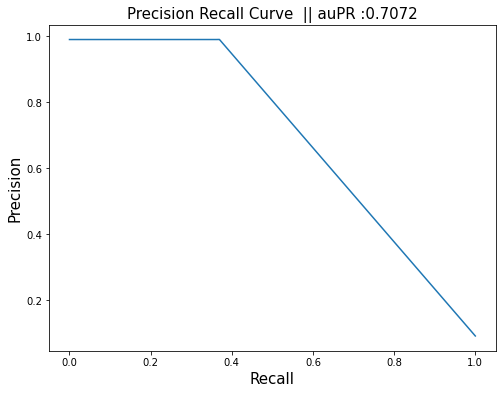

AUC : 0.7072 
Num anomalies 2084


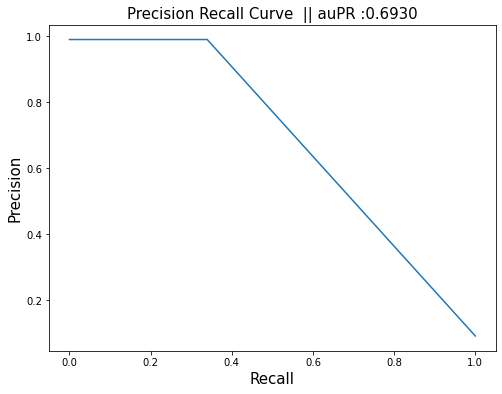

AUC : 0.6930 
Num anomalies 2084


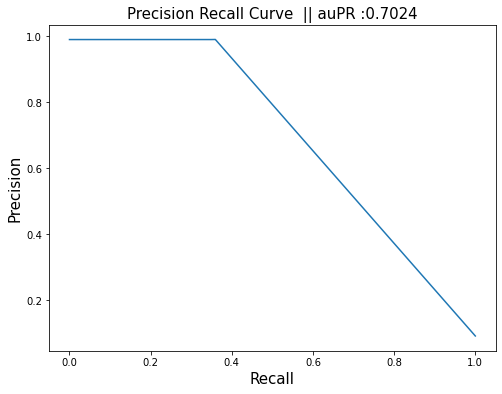

AUC : 0.7024 
Num anomalies 2084


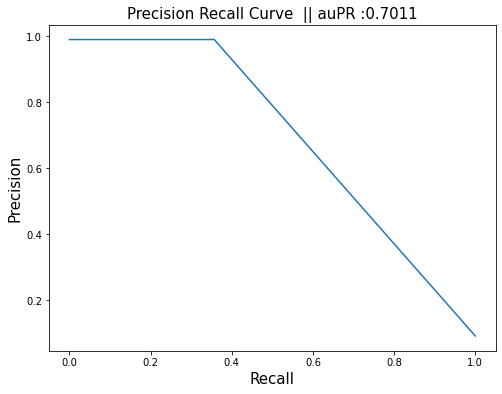

AUC : 0.7011 
Num anomalies 2084


In [ ]:
test_eval()

In [176]:
def viz_loss(losses):
    import matplotlib.pyplot as plt
    plt.figure(figsize=[8,6])
    plt.plot(list(range(len(losses[:]))),losses[:])
    plt.show()
    return

In [100]:
train_X = data_dict['train']


test_norm_X = data_dict['test']

In [101]:
test_anom_df = data_dict['anom_3']
test_anom_X = test_anom_df.values
x1 = test_norm_X
x2 = test_anom_X

In [102]:
# pos,neg = model_data_fetcher.fetch_model_data('kddcup')

In [103]:

x0 = train_X

In [104]:
neg.shape

(48646, 10, 122)

In [105]:
neg1 = np.reshape(neg,[ neg.shape[0]* neg.shape[1] , neg.shape[2]])
np.random.shuffle(neg1)
neg1.shape

(486460, 122)

In [106]:
x3 = neg1[:10000]

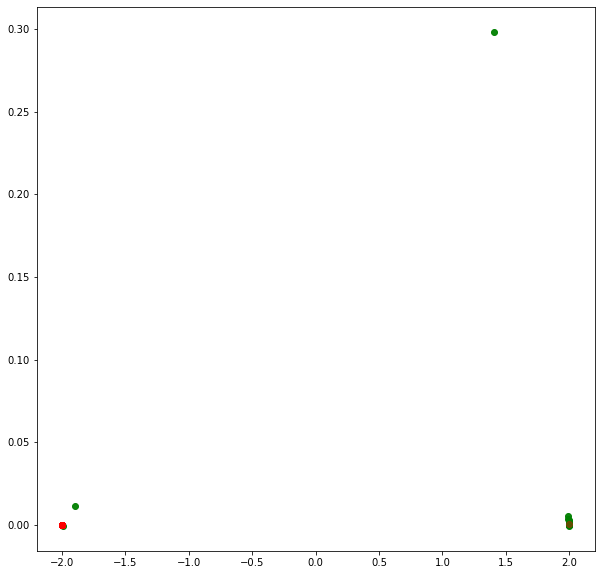

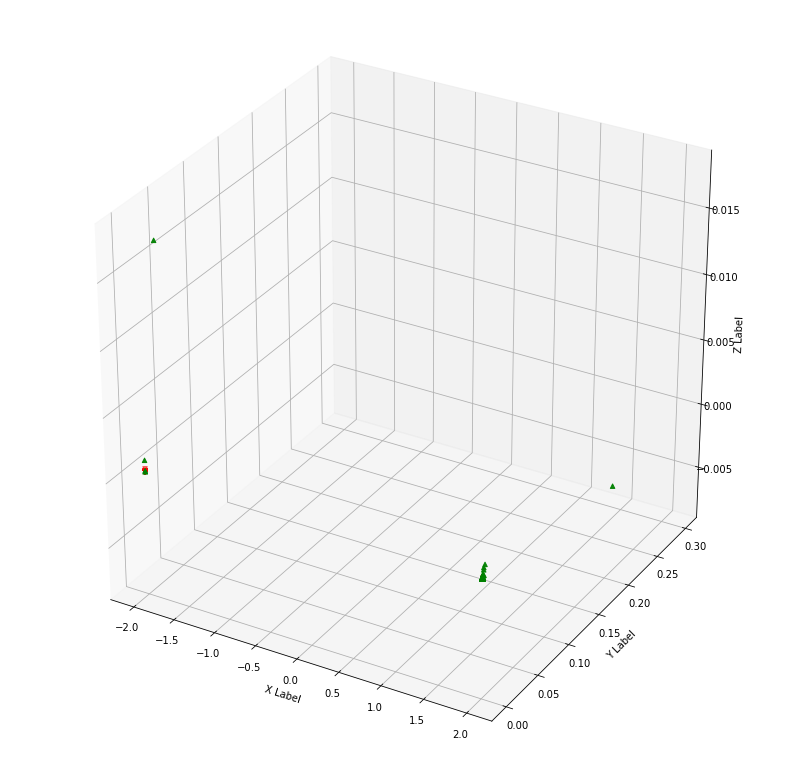

In [115]:
visualize( ae_model, x0, x3 )

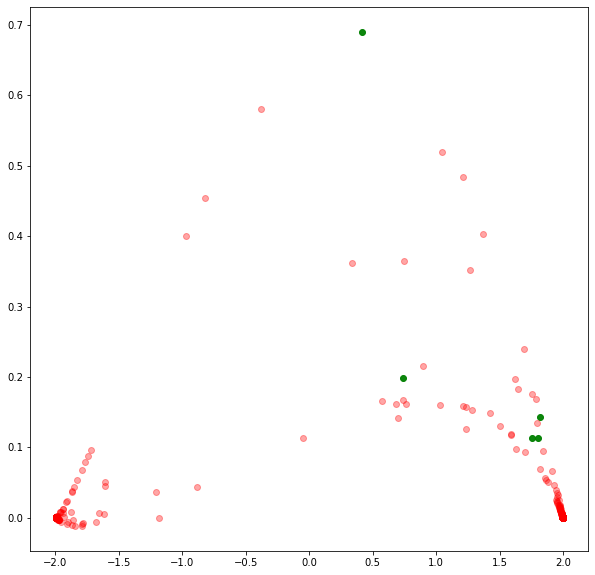

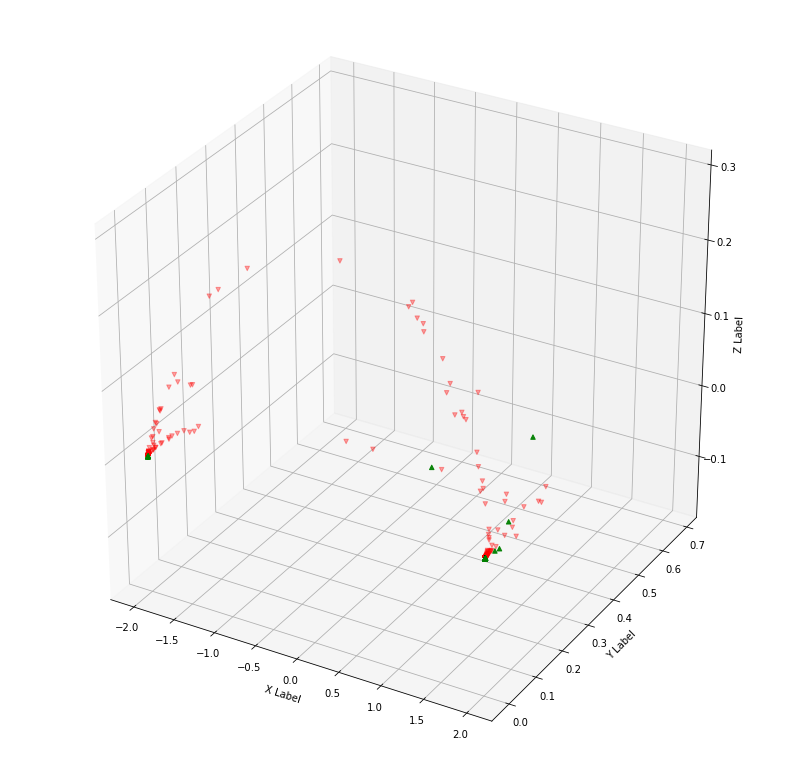

In [116]:
visualize( ae_model, x1, x2 )

In [186]:
x3_scores = ae_model.get_score(x3)
np.min(x3_scores), np.median(x3_scores), np.max(x3_scores)

(0.012228724, 0.01222896, 0.99218905)

In [187]:
x2_scores = ae_model.get_score(x2)

np.min(x2_scores), np.median(x2_scores), np.max(x2_scores)

(0.0122294435, 0.9921923, 0.99220896)

In [198]:

x1_scores = ae_model.get_score(x1)
np.min(x1_scores), np.median(x1_scores), np.max(x1_scores)

(0.012229616, 0.9922084, 0.99220896)

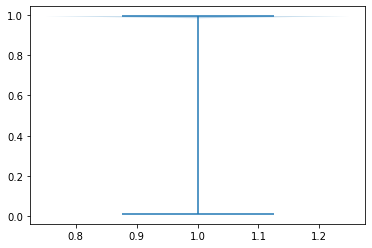

In [197]:
plt.violinplot(np.array(x1_scores))
plt.show()

In [190]:
def _normalize_(val, _min,_max):
    return (val -_min)/(_max - _min)

In [191]:
ae_model.mode = 'test'

x1_scores = ae_model.get_score(x1)
x2_scores = ae_model.get_score(x2)

In [192]:
x1 = test_norm_X
x2 = test_anom_X

In [193]:
res_data = []
labels = [ 1 for _ in range(x1.shape[0])] +  [0 for _ in range(x2.shape[0])] 
_scores = np.concatenate([x1_scores, x2_scores],axis=0)

for i,j in zip(_scores, labels):
    res_data.append((i[0],j))
    
res_df = pd.DataFrame(res_data, columns=['score','label'] )
res_df = res_df.sort_values(by=['score'],ascending= True)
_max = max(res_df['score'])
_min = min(res_df['score'])



res_df['score'] = res_df['score'].parallel_apply(
    _normalize_,
    args=(_min,_max, )
)
res_df

,score,label
21281,0.000000e+00,0
14571,1.758146e-07,1
3531,1.758146e-07,1
7038,1.834174e-07,1
16263,3.845112e-06,1
...,...,...
10062,1.000000e+00,1
3502,1.000000e+00,1
20044,1.000000e+00,1
12629,1.000000e+00,1


In [194]:
max(res_df['score']),min(res_df['score'])

(1.0, 0.0)

In [195]:
_max = max(res_df['score'])
_min = min(res_df['score'])
step = (_max - _min)/ 100

# Vary the threshold
thresh = _min + step
num_anomalies = x2.shape[0]
print('Num anomalies',num_anomalies )
P = []
R = [0]

while thresh <= _max + step :
    
    sel = res_df.loc[res_df['score'] <= thresh]
    if len(sel) == 0 :
        thresh += step
        continue

    correct = sel.loc[sel['label'] == 0 ]
    
    prec = len(correct)/ len(sel)
    rec = len(correct)/num_anomalies
    
    print(thresh, prec, rec, '|| ', len(sel) ,'||' ,len(correct))
    P.append(prec)
    R.append(rec)
    thresh += step
    
P = [P[0]] + P

Num anomalies 2084
0.01 0.986013986013986 0.2029750479846449 ||  429 || 423
0.02 0.9864864864864865 0.21017274472168906 ||  444 || 438
0.03 0.9868131868131869 0.2154510556621881 ||  455 || 449
0.04 0.9868421052631579 0.21593090211132437 ||  456 || 450
0.05 0.9869848156182213 0.21833013435700577 ||  461 || 455
0.060000000000000005 0.9870410367170627 0.21928982725527832 ||  463 || 457
0.07 0.9870410367170627 0.21928982725527832 ||  463 || 457
0.08 0.9870689655172413 0.21976967370441458 ||  464 || 458
0.09 0.9870689655172413 0.21976967370441458 ||  464 || 458
0.09999999999999999 0.9870967741935484 0.22024952015355087 ||  465 || 459
0.10999999999999999 0.9870967741935484 0.22024952015355087 ||  465 || 459
0.11999999999999998 0.9871244635193133 0.22072936660268713 ||  466 || 460
0.12999999999999998 0.9872340425531915 0.22264875239923224 ||  470 || 464
0.13999999999999999 0.9872611464968153 0.22312859884836853 ||  471 || 465
0.15 0.9873150105708245 0.22408829174664108 ||  473 || 467
0.16 0.9

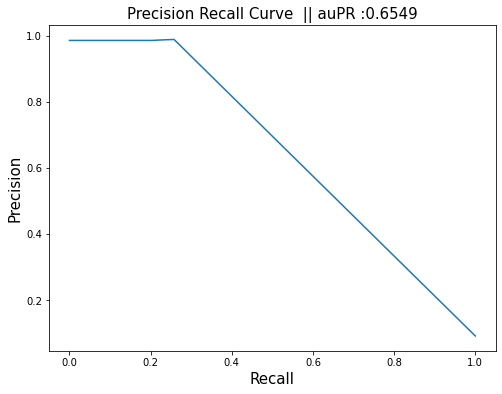

AUC : 0.6549 


In [196]:

from sklearn.metrics import auc
pr_auc = auc( R, P)

plt.figure(figsize=[8,6])
plt.plot(R,P)
plt.title('Precision Recall Curve  || auPR :' + "{:0.4f}".format(pr_auc), fontsize=15 )
plt.xlabel('Recall',fontsize=15)
plt.ylabel('Precision',fontsize=15)
plt.show()


print("AUC : {:0.4f} ".format(pr_auc))

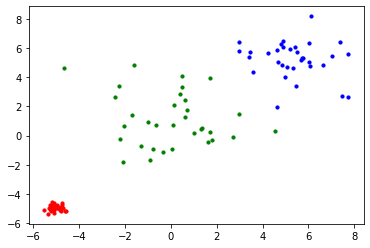

Number of cluster centers calculated : 4


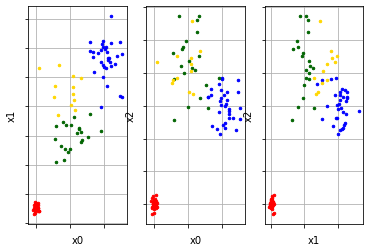

[array([5.35054598, 3.68771659])]


[[-4.957007090913727, -5.0115476154679115],
 [1.103508013001677, -1.0740079912115943],
 [1.0081270544323917, 2.3410526260307187],
 [4.899507476842758, 4.9839302284736595]]

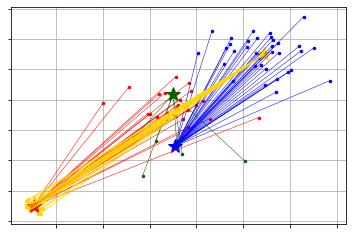

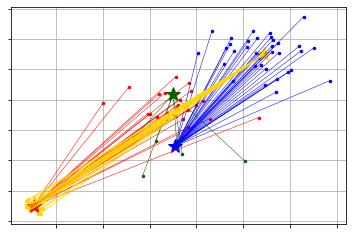

In [62]:
# Visualize obtained results
kmeans_visualizer.show_clusters(X, clusters, final_centers)

In [39]:
import numpy as np


INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [40]:
df_dict

In [41]:
idx = np.arange(num_data)
np.random.shuffle(idx)

In [47]:
idx[:int(0.7*idx.shape[0])]

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


array([8279, 3823, 9476, ..., 6352, 4989, 7778])

,protocol_type_0,protocol_type_1,protocol_type_2,service_0,service_1,service_2,service_3,service_4,service_5,service_6,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
64140,0,1,0,0,0,0,0,0,0,0,...,0.396078,0.396078,1.00,0.00,0.01,0.00,0.01,0.01,0.00,0.00
8100,0,1,0,0,0,0,0,0,0,0,...,0.113725,0.450980,1.00,0.00,0.03,0.17,0.00,0.01,0.90,0.85
23256,0,1,0,0,0,0,0,0,0,0,...,0.019608,0.019608,1.00,0.00,0.20,0.00,0.00,0.00,0.00,0.00
33474,0,1,0,0,0,0,0,0,0,0,...,0.003922,0.752941,1.00,0.00,1.00,0.17,0.00,0.00,1.00,1.00
55654,0,0,1,0,0,0,0,0,0,0,...,0.027451,0.023529,0.86,0.29,0.14,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17609,0,1,0,0,0,0,0,0,0,0,...,0.152941,1.000000,1.00,0.00,0.03,0.02,0.00,0.00,0.00,0.00
47807,0,1,0,0,0,0,0,0,0,0,...,0.200000,0.333333,0.61,0.08,0.61,0.02,0.00,0.00,0.00,0.00
68587,0,1,0,0,0,0,0,0,0,0,...,0.341176,1.000000,1.00,0.00,0.01,0.02,0.00,0.00,0.01,0.00
14935,0,1,0,0,0,0,0,0,0,0,...,1.000000,0.486275,0.49,0.02,0.00,0.00,0.00,0.01,0.00,0.00
